In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#export
from exp.nb_07 import *

# BatchNorm
> Layer Normalization 

With basic parameter initialization we can only get so far. The next step would be normalize our activations inside the model. 

This is idea behind BatchNorm and its many variants.

## Data, Model, and Runner

We'll start how we normally do: get the mnist data, put together our callbacks, runner and learner and then train.

In [3]:
x_train, y_train, x_valid, y_valid = get_data()

train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)

nh,bs = 50,512
c = y_train.max().item()+1
loss_func = F.cross_entropy

data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [4]:
mnist_view = view_tfm(1,28,28)
callbacks = [
    Recorder,
    partial(AvgStatsCallback, accuracy),
    partial(BatchTransformXCallback, mnist_view),
    CudaCallback
]

In [5]:
nfs = [8,16,32,64,64]

learn, run = get_learn_run(data, nfs, conv_layer, lr=0.4, cbs=callbacks)

Layer Initialized torch.Size([8, 1, 5, 5])
Layer Initialized torch.Size([16, 8, 3, 3])
Layer Initialized torch.Size([32, 16, 3, 3])
Layer Initialized torch.Size([64, 32, 3, 3])
Layer Initialized torch.Size([64, 64, 3, 3])


In [6]:
%time run.fit(3, learn)

train: [1.4436640625, tensor(0.5237, device='cuda:0')]
valid: [0.3139478759765625, tensor(0.8942, device='cuda:0')]
train: [0.22821251953125, tensor(0.9300, device='cuda:0')]
valid: [0.3756976318359375, tensor(0.8935, device='cuda:0')]
train: [0.12748861328125, tensor(0.9607, device='cuda:0')]
valid: [0.1394625244140625, tensor(0.9558, device='cuda:0')]
Wall time: 6.05 s


## Norms

### Custom BatchNorm Module

We'll start by implementing BatchNorm from stratch based on the paper "Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift" by Sergey Ioffe and Christian Szegedy

BatchNorm comes down to essentially 4 steps:

1. Find the mean of the mini-batch.
$$ \mu_{\beta} \leftarrow \frac{1}{m} \sum_{i=1}^m x_i$$

2. Find the variance of the mini-batch:
$$\sigma^2_{\beta} \leftarrow \frac{1}{m} \sum_{i=1}^m (x_i - \mu_{\beta})^2$$


3. Normalize the mini-batch by subtracting the mean and dividing by the squareroot of the variance plus a small value epsilon :
$$ \hat{x}_i \leftarrow \frac{x_i - \mu_{\beta}}{\sqrt{\sigma_{\beta}^2 + \epsilon} }$$

4. Scale and shift:
$$y_i \leftarrow \gamma \hat{x}_i + \beta \equiv BN_{\gamma, \beta}(x_i)$$

This is BatchNorm.

We'll implement this in a similar way as we created the `Generalized ReLU` - as a `nn.Module` which can easily be placed into our `get_conv_layers` function as any other module we're using (linear, Conv2d, etc)

In [7]:
class BatchNorm(nn.Module):
    
    def __init__(self, nf, mom=0.1, eps= 1e-5):
        super().__init__()
        self.mom, self.eps = mom, eps
        
        # learnable parameters gamma and beta from the equation above
        self.mults = nn.Parameter(torch.ones(nf, 1,1)) 
        self.adds = nn.Parameter(torch.zeros(nf, 1,1)) 
    
        # buffers that will be serialized and sent to the GPU but not optimized 
        self.register_buffer('vars', torch.ones(1,nf,1,1))
        self.register_buffer('means', torch.zeros(1,nf,1,1))
        
    def update_stats(self, x):
        # mini-batch stats
        m = x.mean((0,2,3), keepdim=True) # leaves a mean for each channel
        v = x.var((0,2,3), keepdim=True)
        
        # linear interpolation
        self.means.lerp_(m, self.mom)
        self.vars.lerp_(v, self.mom)
        return m,v
         
    def forward(self, x):
        
        if self.training: 
            with torch.no_grad(): m,v = self.update_stats(x) # if train mode get stats of batch
        else:
            m,v = self.means, self.vars # if inference use saved means and vars
        
        # normalize the batch    
        x = (x-m) / (v+self.eps).sqrt()
        
        # scale and shift by learnable parameters
        return x*self.mults + self.adds

#### `register_buffer`

We use the Pytorch `register_buffer` method for the `mults` and `adds` attributes. It adds some functionality that will helpful later:
    
    1. Moves to GPU 
    2. When the model is saved/serialized later, it saves any tensors registered as buffers.
    3. Buffers are not trained by the optimizer - they won’t be returned in model.parameters(), so that the optimizer won’t have a chance to update them.
    

If you have parameters in your model, which should be saved and restored in the `state_dict`, but not trained by the optimizer, you should register them as buffers.

In [8]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.my_tensor = torch.randn(1)
        self.register_buffer('my_buffer', torch.randn(1))
        self.my_param = nn.Parameter(torch.randn(1))
        
    def forward(self, x):
            return x

In this case `my_tensor` is not saved as a `parameter` or `buffer` - its simply a class attribute.

In [9]:
mm = MyModel()
print(mm.my_tensor)

tensor([-1.2354])


There is only one parameter in the model:

In [10]:
for l in mm.parameters(): print(l)

Parameter containing:
tensor([-2.6761], requires_grad=True)


And the `state_dict` contains `my_param` and `my_buffer`

In [11]:
print(mm.state_dict())

OrderedDict([('my_param', tensor([-2.6761])), ('my_buffer', tensor([-1.1743]))])


Now if we push everything onto the GPU we can see that the parameters and buffers get pushed onto the GPU but the `my_tensor` remains on the CPU:

In [12]:
mm.cuda()
print(mm.my_tensor)

tensor([-1.2354])


In [13]:
print(mm.state_dict())

OrderedDict([('my_param', tensor([-2.6761], device='cuda:0')), ('my_buffer', tensor([-1.1743], device='cuda:0'))])


#### Mean of mini-batch

It's helpful for BatchNorm and the other types of Norm to keep in mind how average over a dimension:

In [14]:
a = torch.arange(1.,5.)
b = a.expand(3, 4); b

tensor([[1., 2., 3., 4.],
        [1., 2., 3., 4.],
        [1., 2., 3., 4.]])

In [15]:
b.shape

torch.Size([3, 4])

The Pytorch `mean` function reduces over whichever dimension you give it.

Here we average over the rows (dim=0) and with `keepdim=True` we get a tensor of `[1,4]` with the average of every element in each row:

In [16]:
bm = b.mean(0, keepdim=True); bm, bm.shape

(tensor([[1., 2., 3., 4.]]), torch.Size([1, 4]))

Doing the same thing for the columns (dim=1) we get:

In [17]:
bm = b.mean(1, keepdim=True); bm, bm.shape

(tensor([[2.5000],
         [2.5000],
         [2.5000]]),
 torch.Size([3, 1]))

Let's try this with a mini-batch of data. 

A mini-batch starts as a rank 3 tensor. But `conv2d` function expects `[batch_size, channels, height, width]` so let's reshape it:

In [18]:
xb, yb = next(iter(data.train_dl))
xb = xb.view(512,1,28,-1); xb.shape

torch.Size([512, 1, 28, 28])

In [19]:
num_filters = 8
channels = 1
momentum = .1

The shape of our filter should be ` [number_of_filters, input_channels, height, width]`

In [20]:
fil = torch.randn((num_filters,channels,5,5))

In [21]:
out = F.relu(F.conv2d(xb, fil, stride=2)); out.shape

torch.Size([512, 8, 12, 12])

Let's average over the `0,2,3` dimensions of the output tensor. 

This means we will average over the mini-batch, height and width. Leaving us with a mean for each filter:

In [22]:
m = out.mean((0,2,3), keepdim=True); m.shape

torch.Size([1, 8, 1, 1])

Here we average over the 0 dim or rows - this results in a mean for every row - basically every image:

In [23]:
out.mean((1,2,3), keepdim=True).shape

torch.Size([512, 1, 1, 1])

And here the height and width:

In [24]:
out.mean((2,3), keepdim=True).shape

torch.Size([512, 8, 1, 1])

In [25]:
out.mean((0,1,3), keepdim=True).shape

torch.Size([1, 1, 12, 1])

#### `lerp`

Pytorch `torch.lerp` finds the exponentially weighted averaged in kind of a weird way.

    Does a linear interpolation of two tensors `start` (given by input) and `end` based on a scalar or tensor weight and returns the resulting out tensor.

$$ \text{out}_i = \text{start}_i + \text{weight}_i \times (\text{end}_i - \text{start}_i) $$

In [26]:
start_mean = torch.zeros(1,num_filters,1,1)

In [27]:
start_mean.lerp(m, momentum)

tensor([[[[0.0099]],

         [[0.0744]],

         [[0.0836]],

         [[0.0777]],

         [[0.0024]],

         [[0.0017]],

         [[0.1276]],

         [[0.1191]]]])

The normal equation for the exponentially weighted moving average is this:

$$ S_t = \alpha \cdot S_{t-1} + (1-\alpha) \cdot x $$

Which gives us the same result:

In [28]:
.9*start_mean + (1.-.9)*m == start_mean.lerp(m, momentum)

tensor([[[[True]],

         [[True]],

         [[True]],

         [[True]],

         [[True]],

         [[True]],

         [[True]],

         [[True]]]])

### Applying Custom BatchNorm

Now we'll need to tweak our `conv_layer` function to add a `BatchNorm` to each conv layer:

In [29]:
def conv_layer(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    # no bias if using bn
    layers = [nn.Conv2d(ni, nf, kernel_size=ks, padding=ks//2, stride=stride, bias=not bn), GeneralRelu(**kwargs)]
    if bn: layers.append(BatchNorm(nf, **kwargs))
    return nn.Sequential(*layers)

Let's also refactor our `init_cnn` using the factory method and make a recursive `init_cnn_` that traverses the model's modules:

In [30]:
#export
def init_cnn_(m, func):
    if isinstance(m, nn.Conv2d):
        func(m.weight, a=0.1)
        if getattr(m, 'bias', None) is not None: m.bias.data.zero_()
    for l in m.children(): init_cnn_(l, func)

def init_cnn(model, uniform=False):
    initzer = init.kaiming_normal_ if not uniform else init.kaiming_uniform_
    init_cnn_(model, initzer)

Reload `get_learn_run` with new functions:

In [31]:
#export
def get_learn_run(data, nfs, layer, lr, cbs=None, opt_func=None, uniform=False, **kwargs):
    model = get_cnn_model(data, nfs, layer, **kwargs)
    init_cnn(model, uniform=uniform)
    return get_runner(model, data, lr=lr, cbs=cbs, opt_func=opt_func)

train: [0.36423140625, tensor(0.8943, device='cuda:0')]
valid: [0.1718577392578125, tensor(0.9469, device='cuda:0')]


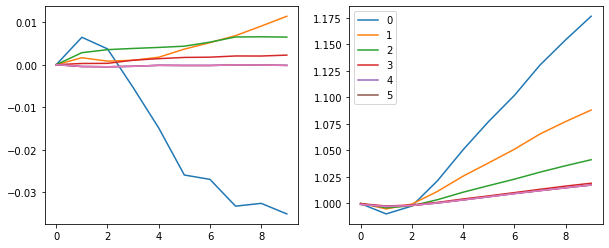

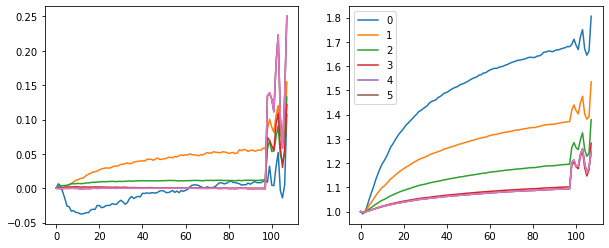

In [32]:
learn, run = get_learn_run(data, nfs, conv_layer, 0.4, cbs=callbacks)

with Hooks(learn.model, append_stats) as hooks:
    run.fit(1, learn)
    fig, (ax0, ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks[:-1]:
        ms, ss = h.stats[0], h.stats[1]
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
    plt.legend(range(6))
    
    fig, (ax0, ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks[:-1]:
        ms, ss = h.stats[0], h.stats[1]
        ax0.plot(ms)
        ax1.plot(ss)
    plt.legend(range(6))
    

With a learning rate of `0.4` we get to `89%` validation accuracy after 1 epoch.

Let's turn up the learning rate and see how our means and stds hold up.

train: [0.26825953125, tensor(0.9156, device='cuda:0')]
valid: [0.1913160888671875, tensor(0.9414, device='cuda:0')]


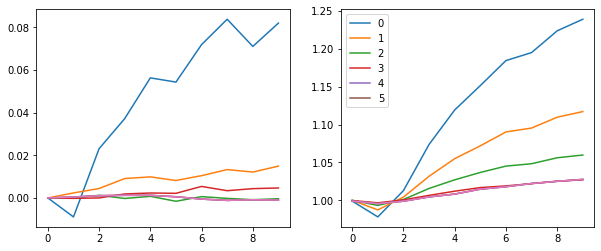

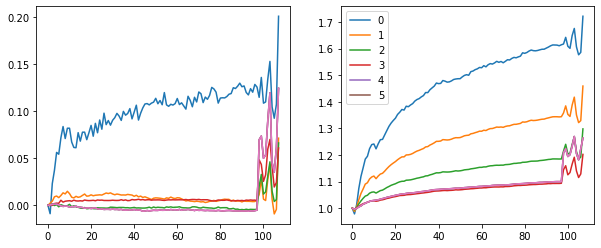

In [33]:
learn, run = get_learn_run(data, nfs, conv_layer, 0.9, cbs=callbacks)

with Hooks(learn.model, append_stats) as hooks:
    run.fit(1, learn)
    fig, (ax0, ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks[:-1]:
        ms, ss = h.stats[0], h.stats[1]
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
    plt.legend(range(6))
    
    fig, (ax0, ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks[:-1]:
        ms, ss = h.stats[0], h.stats[1]
        ax0.plot(ms)
        ax1.plot(ss)
    plt.legend(range(6))
    

 Accuracy improved.
 
 But what is happening in the last iterations? The means and stds start jumping around. Those are the validations batches...

In [34]:
learn, run = get_learn_run(data, nfs, conv_layer, 1.0, cbs=callbacks)

In [35]:
run.fit(4, learn)

train: [0.24370298828125, tensor(0.9241, device='cuda:0')]
valid: [0.13462109375, tensor(0.9589, device='cuda:0')]
train: [0.0794951416015625, tensor(0.9754, device='cuda:0')]
valid: [0.2126443603515625, tensor(0.9356, device='cuda:0')]
train: [0.0590952734375, tensor(0.9818, device='cuda:0')]
valid: [0.49616767578125, tensor(0.8379, device='cuda:0')]
train: [0.04764673828125, tensor(0.9851, device='cuda:0')]
valid: [0.10040128173828125, tensor(0.9700, device='cuda:0')]


### Pytorch BatchNorm Module

And now for the Pytorch `nn.BatchNorm2d` module:

In [36]:
#export
def conv_layer(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    # no bias if using bn
    layers = [nn.Conv2d(ni, nf, kernel_size=ks, padding=ks//2, stride=stride, bias=not bn), GeneralRelu(**kwargs)]
    if bn: layers.append(nn.BatchNorm2d(nf, eps=1e-05, momentum=0.1))
    return nn.Sequential(*layers)

In [37]:
learn, run = get_learn_run(data, nfs, conv_layer, 0.7, cbs=callbacks)

In [38]:
%time run.fit(4, learn)

train: [0.24448779296875, tensor(0.9255, device='cuda:0')]
valid: [0.1026760498046875, tensor(0.9676, device='cuda:0')]
train: [0.0691066650390625, tensor(0.9797, device='cuda:0')]
valid: [0.06471670532226563, tensor(0.9808, device='cuda:0')]
train: [0.0448808837890625, tensor(0.9864, device='cuda:0')]
valid: [0.05888819580078125, tensor(0.9818, device='cuda:0')]
train: [0.03253665283203125, tensor(0.9898, device='cuda:0')]
valid: [0.0585130615234375, tensor(0.9839, device='cuda:0')]
Wall time: 5.37 s


To improve this even more let's add our param scheduler callback:

In [39]:
sched = combine_scheds([0.3, 0.7], [sched_lin(0.6, 2.), sched_lin(2., 0.1)])

In [40]:
learn, run = get_learn_run(data, nfs, conv_layer, 0.7, cbs=callbacks+[partial(ParamScheduler, 'lr', sched)])

In [41]:
run.fit(8, learn)

train: [0.26448447265625, tensor(0.9193, device='cuda:0')]
valid: [0.12890528564453124, tensor(0.9604, device='cuda:0')]
train: [0.07978875, tensor(0.9756, device='cuda:0')]
valid: [0.09081660766601563, tensor(0.9748, device='cuda:0')]
train: [0.059111103515625, tensor(0.9818, device='cuda:0')]
valid: [0.07796253051757812, tensor(0.9764, device='cuda:0')]
train: [0.03394944580078125, tensor(0.9890, device='cuda:0')]
valid: [0.0592250732421875, tensor(0.9830, device='cuda:0')]
train: [0.019360958251953126, tensor(0.9939, device='cuda:0')]
valid: [0.05042833557128906, tensor(0.9850, device='cuda:0')]
train: [0.01070795654296875, tensor(0.9974, device='cuda:0')]
valid: [0.046993450927734375, tensor(0.9864, device='cuda:0')]
train: [0.005766049194335938, tensor(0.9989, device='cuda:0')]
valid: [0.04836365356445312, tensor(0.9857, device='cuda:0')]
train: [0.0038416171264648437, tensor(0.9996, device='cuda:0')]
valid: [0.046897659301757814, tensor(0.9868, device='cuda:0')]


We're at 98.7% accuracy for our validation set - that means we're wrong on about 650 out of the 50,000 digits we see. 

In [42]:
49350 / len(data.valid_ds) 

0.987

### Layer Norm

From [the paper](https://arxiv.org/abs/1607.06450): "*batch normalization cannot be applied to online learning tasks or to extremely large distributed models where the minibatches have to be small*".

In [43]:
class LayerNorm(nn.Module):
    __constants__ = ['eps']
    def __init__(self, eps=1e-5):
        super().__init__()
        self.eps = eps
        self.mult= nn.Parameter(tensor(1.)) # learnable gamma and beta
        self.add = nn.Parameter(tensor(0.))
        
    def forward(self,x):
        m = x.mean((1,2,3), keepdim=True) # mean of each image
        v = x.var((1,2,3), keepdim=True)
        
        x = (x-m) / ((v - self.eps).sqrt())
        return x*self.mult + self.add

In [44]:
def conv_ln(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=True),
              GeneralRelu(**kwargs)]
    if bn: layers.append(LayerNorm())
    return nn.Sequential(*layers)

In [45]:
learn,run = get_learn_run(data, nfs, conv_ln, 0.8,  cbs=callbacks)

In [46]:
run.fit(1, learn)

train: [nan, tensor(0.1232, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]


Not working...

### Instance Norm

From [the paper](https://arxiv.org/abs/1607.08022):

The key difference between **contrast** and batch normalization is that the latter applies the normalization to a  whole batch of images instead for single ones:

\begin{equation}\label{eq:bnorm}
    y_{tijk} =  \frac{x_{tijk} - \mu_{i}}{\sqrt{\sigma_i^2 + \epsilon}},
    \quad
    \mu_i = \frac{1}{HWT}\sum_{t=1}^T\sum_{l=1}^W \sum_{m=1}^H x_{tilm},
    \quad
    \sigma_i^2 = \frac{1}{HWT}\sum_{t=1}^T\sum_{l=1}^W \sum_{m=1}^H (x_{tilm} - mu_i)^2.
\end{equation}

In order to combine the effects of instance-specific normalization and batch normalization, we propose to replace the latter by the *instance normalization* (also known as *contrast normalization*) layer:

\begin{equation}\label{eq:inorm}
    y_{tijk} =  \frac{x_{tijk} - \mu_{ti}}{\sqrt{\sigma_{ti}^2 + \epsilon}},
    \quad
    \mu_{ti} = \frac{1}{HW}\sum_{l=1}^W \sum_{m=1}^H x_{tilm},
    \quad
    \sigma_{ti}^2 = \frac{1}{HW}\sum_{l=1}^W \sum_{m=1}^H (x_{tilm} - mu_{ti})^2.
\end{equation}

In [47]:
class InstanceNorm(nn.Module):
    __constants__ = ['eps']
    def __init__(self, nf, eps=1e-0):
        super().__init__()
        self.eps = eps
        self.mults = nn.Parameter(torch.ones (nf,1,1))
        self.adds  = nn.Parameter(torch.zeros(nf,1,1))

    def forward(self, x):
        m = x.mean((2,3), keepdim=True)
        v = x.var ((2,3), keepdim=True)
        res = (x-m) / ((v+self.eps).sqrt())
        return res*self.mults + self.adds

In [48]:
def conv_in(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=True),
              GeneralRelu(**kwargs)]
    if bn: layers.append(InstanceNorm(nf))
    return nn.Sequential(*layers)

In [49]:
learn,run = get_learn_run(data, nfs, conv_in, 0.8,  cbs=callbacks)

In [50]:
run.fit(1, learn)

train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]


### Group Norm

## Fix Small Batch Sizes

### The problem with small Batches and BatchNorm

Let's reload our DataBunch is a batch size of 2 and attempt to train. 

In [51]:
data = DataBunch(*get_dls(train_ds, valid_ds, 2), c)

In [52]:
def conv_layer(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    # no bias if using bn
    layers = [nn.Conv2d(ni, nf, kernel_size=ks, padding=ks//2, stride=stride, bias=not bn), GeneralRelu(**kwargs)]
    if bn: layers.append(nn.BatchNorm2d(nf, eps=1e-05, momentum=0.1)) 
    return nn.Sequential(*layers)

In [53]:
learn, run = get_learn_run(data, nfs, conv_layer, 0.3, cbs=callbacks)

In [54]:
%time run.fit(2, learn)

train: [2.28125984375, tensor(0.1923, device='cuda:0')]
valid: [36.268878125, tensor(0.2849, device='cuda:0')]
train: [2.22784796875, tensor(0.2264, device='cuda:0')]
valid: [1825470.0544, tensor(0.3190, device='cuda:0')]
Wall time: 4min 53s


First thing to note is how long it takes, more than for 4 minutes for 2 epochs.

Secondly, the loss gets blown out. 

    "When we compute the statistics (mean and std) for a BatchNorm Layer on a small batch, it is possible that we get a standard deviation very close to 0. because there aren't many samples (the variance of one thing is 0. since it's equal to its mean)."


Let's try to understand this in more detail by running a mini-batch through our first layer of our trained model to see what the output looks like after a manual BatchNorm:

In [55]:
xb, yb = next(iter(data.train_dl));
xb = xb.view(2, 1, 28, 28).cuda(); xb.shape

torch.Size([2, 1, 28, 28])

In [56]:
out = F.relu(learn.model[0][0](xb)); out.shape

torch.Size([2, 8, 14, 14])

In [66]:
out_mean = out.mean((0,2,3), keepdim=True)
out_var = out.var((0,2,3), keepdim=True)

Without adding the epsilon sqrt, the denominator, is zero in a few places. This means we're dividing by zero.

In [67]:
out_var.sqrt()

tensor([[[[ 0.4190]],

         [[ 0.0000]],

         [[25.6605]],

         [[ 2.8807]],

         [[16.9091]],

         [[ 0.0000]],

         [[38.4943]],

         [[60.0993]]]], device='cuda:0', grad_fn=<SqrtBackward>)

The result, even with adding a small epsilon, is not good. 

Portions of the activations have gone to zero.

In [62]:
(out - out_mean).div(out_var.add_(1e-5).sqrt())

tensor([[[[-0.1995, -0.1995, -0.1995,  ..., -0.1995, -0.1995, -0.1995],
          [-0.1995, -0.1995, -0.1995,  ..., -0.1995, -0.1995, -0.1995],
          [-0.1995, -0.1995, -0.1995,  ..., -0.1995, -0.1995, -0.1995],
          ...,
          [-0.1995, -0.1995, -0.1995,  ..., -0.1995, -0.1995, -0.1995],
          [-0.1995, -0.1995, -0.1995,  ..., -0.1995, -0.1995, -0.1995],
          [-0.1995, -0.1995, -0.1995,  ..., -0.1995, -0.1995, -0.1995]],

         [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

         [[-0.6047, -0.6047, -0.6047,  ..., -0.6047, -0.6047, -0.6047],
          [-0.6047, -0.6047, -

### Running BatchNorm

Fastai proposed this solution to smooth the mean and variance to fix the small batch problem with BatchNorm. 

In [77]:
class RunningBatchNorm(nn.Module):
    def __init__(self, nf, mom=0.1, eps=1e-5):
        super().__init__()
        self.mom,self.eps = mom,eps
        self.mults = nn.Parameter(torch.ones (nf,1,1))
        self.adds = nn.Parameter(torch.zeros(nf,1,1))
        self.register_buffer('sums', torch.zeros(1,nf,1,1))
        self.register_buffer('sqrs', torch.zeros(1,nf,1,1))
        self.register_buffer('batch', tensor(0.))
        self.register_buffer('count', tensor(0.))
        self.register_buffer('step', tensor(0.))
        self.register_buffer('dbias', tensor(0.))

    def update_stats(self, x):
        bs,nc,*_ = x.shape
        self.sums.detach_()
        self.sqrs.detach_()
        dims = (0,2,3)
        s = x.sum(dims, keepdim=True)
        ss = (x*x).sum(dims, keepdim=True)
        c = self.count.new_tensor(x.numel()/nc)
        mom1 = 1 - (1-self.mom)/math.sqrt(bs-1)
        self.mom1 = self.dbias.new_tensor(mom1)
        self.sums.lerp_(s, self.mom1)
        self.sqrs.lerp_(ss, self.mom1)
        self.count.lerp_(c, self.mom1)
        self.dbias = self.dbias*(1-self.mom1) + self.mom1
        self.batch += bs
        self.step += 1

    def forward(self, x):
        if self.training: self.update_stats(x)
        sums = self.sums
        sqrs = self.sqrs
        c = self.count
        if self.step<100:
            sums = sums / self.dbias
            sqrs = sqrs / self.dbias
            c    = c    / self.dbias
        means = sums/c
        vars = (sqrs/c).sub_(means*means)
        if bool(self.batch < 20): vars.clamp_min_(0.01)
        x = (x-means).div_((vars.add_(self.eps)).sqrt())
        return x.mul_(self.mults).add_(self.adds)

In [78]:
def conv_rbn(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn: layers.append(RunningBatchNorm(nf))
    return nn.Sequential(*layers)

In [79]:
learn,run = get_learn_run(data, nfs, conv_rbn, 0.4, cbs=callbacks)

In [80]:
%time run.fit(1, learn)

train: [0.5010744140625, tensor(0.8656, device='cuda:0')]
valid: [0.535328759765625, tensor(0.9537, device='cuda:0')]
Wall time: 6min 40s


Running BatchNorm appears to fix the problem of small batches. 

### Best Single Epoch

Now we'll use a somewhat larger batch size of 32 and see the best accuracy we can attain. 

In [81]:
data = DataBunch(*get_dls(train_ds, valid_ds, 32), c)

In [82]:
learn,run = get_learn_run(data,nfs, conv_rbn, 0.9, cbs=callbacks
                          +[partial(ParamScheduler,'lr', sched_lin(1., 0.2))])

In [83]:
%time run.fit(1, learn)

train: [0.15532408203125, tensor(0.9522, device='cuda:0')]
valid: [0.07329528198242187, tensor(0.9810, device='cuda:0')]
Wall time: 25.4 s


Time to play around with our param scheduler and see if we can find a sweet spot...

In [90]:
sched = combine_scheds([.2, .8], [sched_cos(.1, 0.9), sched_cos(.9, .7)])

learn,run = get_learn_run(data,nfs, conv_rbn, 0.9, cbs=callbacks
                          +[partial(ParamScheduler,'lr', sched)])

%time run.fit(1, learn)

train: [0.193604140625, tensor(0.9404, device='cuda:0')]
valid: [0.08163214111328125, tensor(0.9775, device='cuda:0')]
Wall time: 25.7 s


In [92]:
sched = combine_scheds([.5, .5], [sched_cos(.5, 1.), sched_cos(1., .09)])

learn,run = get_learn_run(data,nfs, conv_rbn, 0.9, cbs=callbacks
                          +[partial(ParamScheduler,'lr', sched)])

%time run.fit(1, learn)

train: [0.1655712890625, tensor(0.9485, device='cuda:0')]
valid: [0.08204594116210938, tensor(0.9795, device='cuda:0')]
Wall time: 25.1 s


In [93]:
sched = combine_scheds([.7, .3], [sched_cos(.6, 1.1), sched_cos(1.1, .2)])

learn,run = get_learn_run(data,nfs, conv_rbn, 0.9, cbs=callbacks
                          +[partial(ParamScheduler,'lr', sched)])

%time run.fit(1, learn)

train: [0.17512861328125, tensor(0.9461, device='cuda:0')]
valid: [0.07688037719726562, tensor(0.9785, device='cuda:0')]
Wall time: 25.7 s


In [94]:
sched = combine_scheds([.4, .6], [sched_cos(.2, 1.1), sched_cos(1.1, .2)])

learn,run = get_learn_run(data,nfs, conv_rbn, 0.9, cbs=callbacks
                          +[partial(ParamScheduler,'lr', sched)])

%time run.fit(1, learn)

train: [0.17544501953125, tensor(0.9465, device='cuda:0')]
valid: [0.08113848266601563, tensor(0.9791, device='cuda:0')]
Wall time: 25.7 s


In [95]:
sched = combine_scheds([.5, .5], [sched_cos(.4, 1.2), sched_cos(1.2, .2)])

learn,run = get_learn_run(data,nfs, conv_rbn, 0.9, cbs=callbacks
                          +[partial(ParamScheduler,'lr', sched)])

%time run.fit(1, learn)

train: [0.1707545703125, tensor(0.9484, device='cuda:0')]
valid: [0.061299725341796875, tensor(0.9820, device='cuda:0')]
Wall time: 25.4 s


In [98]:
sched = combine_scheds([.5, .5], [sched_cos(.4, 1.3), sched_cos(1.3, .1)])

learn,run = get_learn_run(data,nfs, conv_rbn, 0.9, cbs=callbacks
                          +[partial(ParamScheduler,'lr', sched)])

%time run.fit(1, learn)

train: [0.17492396484375, tensor(0.9469, device='cuda:0')]
valid: [0.3291257568359375, tensor(0.9727, device='cuda:0')]
Wall time: 25.5 s


In [97]:
nb_auto_export()

<IPython.core.display.Javascript object>